In [40]:
import pandas as pd
import numpy as np
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from typing import Tuple, List, Dict, Any

def maximize_csv_row_matching(csv1_path: str, csv2_path: str, 
                             similarity_threshold: float = 0.0,
                             method: str = 'combined',
                             columns_to_exclude: List[str] = None) -> Dict[str, Any]:
    """
    Find optimal row matching between two CSV files to maximize overall similarity.
    
    Parameters:
    -----------
    csv1_path : str
        Path to first CSV file
    csv2_path : str
        Path to second CSV file
    similarity_threshold : float
        Minimum similarity score to consider a match (0-1)
    method : str
        Similarity method: 'numerical', 'textual', 'combined'
    columns_to_exclude : List[str], optional
        List of column names to exclude from matching. Default excludes 'Source in paper' and 'Title_of paper'
    
    Returns:
    --------
    dict containing:
        - 'matches': List of tuples (csv1_idx, csv2_idx, similarity_score)
        - 'unmatched_csv1': List of indices from csv1 that couldn't be matched
        - 'unmatched_csv2': List of indices from csv2 that couldn't be matched
        - 'total_similarity': Overall similarity score
        - 'match_rate': Percentage of rows that found matches
    """
    
    # Read CSV files with error handling for field count mismatch
    # Use error_bad_lines=False to skip problematic lines or usecols to limit columns
    try:
        df1 = pd.read_csv(csv1_path)
        df2 = pd.read_csv(csv2_path)
    except pd.errors.ParserError as e:
        print(f"CSV parsing error: {e}")
        print("Attempting to read with only first 10 columns...")
        # Define the expected 10 column headers
        expected_headers = ["Crop Type", "Crop Yield", "Crop Yield Unit", "Climate Drivers", "Climate Drivers Value", "Climate Drivers Unit", "Experimental Design", "Location", "Time", "Source in paper"]
        try:
            # Try reading with specified headers (will truncate extra columns)
            df1 = pd.read_csv(csv1_path, usecols=range(10), names=expected_headers, header=0)
            df2 = pd.read_csv(csv2_path, usecols=range(10), names=expected_headers, header=0)
        except:
            # Fallback: read all columns and truncate to first 10
            df1 = pd.read_csv(csv1_path, header=0, on_bad_lines='skip')
            df2 = pd.read_csv(csv2_path, header=0, on_bad_lines='skip')
            # Keep only first 10 columns
            df1 = df1.iloc[:, :10]
            df2 = df2.iloc[:, :10]
    
    # Ensure we only have 10 columns maximum (truncate if more)
    if df1.shape[1] > 10:
        print(f"Warning: df1 has {df1.shape[1]} columns, truncating to first 10")
        df1 = df1.iloc[:, :10]
    if df2.shape[1] > 10:
        print(f"Warning: df2 has {df2.shape[1]} columns, truncating to first 10")
        df2 = df2.iloc[:, :10]
    
    # Remove specified columns to exclude from matching
    if columns_to_exclude is None:
        columns_to_exclude = ['Source in paper', 'Title_of paper']
    df1 = df1.drop(columns=[col for col in columns_to_exclude if col in df1.columns])
    df2 = df2.drop(columns=[col for col in columns_to_exclude if col in df2.columns])
    
    print(f"CSV1 shape: {df1.shape}")
    print(f"CSV2 shape: {df2.shape}")
    print(f"Common columns: {set(df1.columns) & set(df2.columns)}")
    
    # Ensure both DataFrames have the same columns
    common_cols = list(set(df1.columns) & set(df2.columns))
    if not common_cols:
        raise ValueError("No common columns found between the two CSV files")
    
    df1_subset = df1[common_cols].copy()
    df2_subset = df2[common_cols].copy()
    
    # Calculate similarity matrix
    similarity_matrix = calculate_similarity_matrix(df1_subset, df2_subset, method)
    
    # Use Hungarian algorithm to find optimal assignment
    # Convert to cost matrix (1 - similarity) for minimization
    cost_matrix = 1 - similarity_matrix
    
    # Handle case where one CSV has more rows than the other
    if df1_subset.shape[0] != df2_subset.shape[0]:
        # Pad the smaller matrix with high costs
        max_size = max(df1_subset.shape[0], df2_subset.shape[0])
        padded_cost_matrix = np.ones((max_size, max_size))
        padded_cost_matrix[:cost_matrix.shape[0], :cost_matrix.shape[1]] = cost_matrix
        row_indices, col_indices = linear_sum_assignment(padded_cost_matrix)
        
        # Filter out padded assignments
        valid_assignments = [
            (r, c) for r, c in zip(row_indices, col_indices)
            if r < df1_subset.shape[0] and c < df2_subset.shape[0]
        ]
    else:
        row_indices, col_indices = linear_sum_assignment(cost_matrix)
        valid_assignments = list(zip(row_indices, col_indices))
    
    # Filter matches by similarity threshold
    matches = []
    matched_csv1_indices = set()
    matched_csv2_indices = set()
    
    for r, c in valid_assignments:
        similarity_score = similarity_matrix[r, c]
        if similarity_score >= similarity_threshold:
            matches.append((r, c, similarity_score))
            matched_csv1_indices.add(r)
            matched_csv2_indices.add(c)
    
    # Find unmatched rows
    unmatched_csv1 = [i for i in range(len(df1_subset)) if i not in matched_csv1_indices]
    unmatched_csv2 = [i for i in range(len(df2_subset)) if i not in matched_csv2_indices]
    
    # Calculate overall metrics
    total_similarity = sum(score for _, _, score in matches) if matches else 0
    total_similarity = total_similarity / len(matches) if matches else 0
    match_rate = len(matches) / max(len(df1_subset), len(df2_subset)) * 100
    
    return {
        'matches': sorted(matches, key=lambda x: x[2], reverse=True),
        'unmatched_csv1': unmatched_csv1,
        'unmatched_csv2': unmatched_csv2,
        'total_similarity': total_similarity,
        'match_rate': match_rate,
        'similarity_matrix': similarity_matrix,
        'df1': df1_subset,
        'df2': df2_subset
    }

def calculate_similarity_matrix(df1: pd.DataFrame, df2: pd.DataFrame, method: str = 'combined') -> np.ndarray:
    """
    Calculate similarity matrix between rows of two DataFrames.
    """
    n1, n2 = len(df1), len(df2)
    similarity_matrix = np.zeros((n1, n2))
    
    for i in range(n1):
        for j in range(n2):
            if method == 'numerical':
                similarity_matrix[i, j] = calculate_numerical_similarity(df1.iloc[i], df2.iloc[j])
            elif method == 'textual':
                similarity_matrix[i, j] = calculate_textual_similarity(df1.iloc[i], df2.iloc[j])
            else:  # combined
                similarity_matrix[i, j] = calculate_combined_similarity(df1.iloc[i], df2.iloc[j])
    
    return similarity_matrix

def calculate_numerical_similarity(row1: pd.Series, row2: pd.Series) -> float:
    """Calculate similarity based on numerical columns."""
    numerical_cols = row1.index[pd.to_numeric(row1, errors='coerce').notna() & 
                               pd.to_numeric(row2, errors='coerce').notna()]
    
    if len(numerical_cols) == 0:
        return 0.0
    
    similarities = []
    for col in numerical_cols:
        val1 = pd.to_numeric(row1[col], errors='coerce')
        val2 = pd.to_numeric(row2[col], errors='coerce')
        
        if pd.isna(val1) or pd.isna(val2):
            similarities.append(0.0)
        elif val1 == val2:
            similarities.append(1.0)
        else:
            # Normalized similarity based on relative difference
            max_val = max(abs(val1), abs(val2))
            if max_val == 0:
                similarities.append(1.0)
            else:
                diff = abs(val1 - val2)
                similarities.append(max(0, 1 - diff / max_val))
    
    return np.mean(similarities)

def calculate_textual_similarity(row1: pd.Series, row2: pd.Series) -> float:
    """Calculate similarity based on textual content."""
    # Convert all values to strings and combine
    text1 = ' '.join(str(val) for val in row1.values if pd.notna(val))
    text2 = ' '.join(str(val) for val in row2.values if pd.notna(val))
    
    if not text1.strip() or not text2.strip():
        return 0.0
    
    # Use TF-IDF for text similarity
    try:
        vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
        tfidf_matrix = vectorizer.fit_transform([text1, text2])
        similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
        return similarity
    except:
        # Fallback to simple string similarity
        return simple_string_similarity(text1, text2)

def calculate_combined_similarity(row1: pd.Series, row2: pd.Series) -> float:
    """Calculate combined numerical and textual similarity."""
    num_sim = calculate_numerical_similarity(row1, row2)
    text_sim = calculate_textual_similarity(row1, row2)
    
    # Weight the similarities (can be adjusted)
    return 0.5 * num_sim + 0.5 * text_sim

def simple_string_similarity(s1: str, s2: str) -> float:
    """Simple string similarity using common words."""
    words1 = set(re.findall(r'\w+', s1.lower()))
    words2 = set(re.findall(r'\w+', s2.lower()))
    
    if not words1 and not words2:
        return 1.0
    if not words1 or not words2:
        return 0.0
    
    intersection = len(words1 & words2)
    union = len(words1 | words2)
    
    return intersection / union if union > 0 else 0.0

def display_matching_results(result: Dict[str, Any], top_n: int = 10):
    """Display the matching results in a readable format."""
    print(f"\n=== CSV Matching Results ===")
    print(f"Total similarity score: {result['total_similarity']:.3f}")
    print(f"Match rate: {result['match_rate']:.1f}%")
    print(f"Number of matches: {len(result['matches'])}")
    print(f"Unmatched rows in CSV1: {len(result['unmatched_csv1'])}")
    print(f"Unmatched rows in CSV2: {len(result['unmatched_csv2'])}")
    
    print(f"\n=== Top {top_n} Matches ===")
    for i, (idx1, idx2, score) in enumerate(result['matches'][:top_n]):
        print(f"{i+1}. CSV1[{idx1}] ↔ CSV2[{idx2}] (similarity: {score:.3f})")
        
        # Show some column values for context
        row1 = result['df1'].iloc[idx1]
        row2 = result['df2'].iloc[idx2]
        
        print("   CSV1:", dict(row1.head(3)))
        print("   CSV2:", dict(row2.head(3)))
        print()

# Example usage:
# result = maximize_csv_row_matching('file1.csv', 'file2.csv', similarity_threshold=0.3)
# display_matching_results(result)


In [41]:
# Example usage with sample data
import tempfile
import os

# Create sample CSV files for demonstration
def create_sample_csvs():
    # Sample data with same columns but different row orders and some variations
    data1 = {
        'name': ['John Doe', 'Jane Smith', 'Bob Johnson', 'Alice Brown'],
        'age': [25, 30, 35, 28],
        'city': ['New York', 'Los Angeles', 'Chicago', 'Boston'],
        'salary': [50000, 75000, 60000, 55000]
    }
    
    data2 = {
        'name': ['Jane Smith', 'Alice Brown', 'John Doe', 'Robert Johnson'], # Similar but slightly different
        'age': [30, 28, 25, 36],  # Bob Johnson -> Robert Johnson with different age
        'city': ['Los Angeles', 'Boston', 'New York', 'Chicago'],
        'salary': [75000, 55000, 50000, 61000]  # Slightly different salary for Robert
    }
    
    df1 = pd.DataFrame(data1)
    df2 = pd.DataFrame(data2)
    
    # Create temporary CSV files
    csv1_path = tempfile.NamedTemporaryFile(mode='w', suffix='.csv', delete=False)
    csv2_path = tempfile.NamedTemporaryFile(mode='w', suffix='.csv', delete=False)
    
    df1.to_csv(csv1_path.name, index=False)
    df2.to_csv(csv2_path.name, index=False)
    
    return csv1_path.name, csv2_path.name

# Run the example
if __name__ == "__main__":
    csv1_path, csv2_path = create_sample_csvs()
    
    try:
        print("=== Sample CSV Files Created ===")
        print("CSV1:")
        print(pd.read_csv(csv1_path))
        print("\nCSV2:")
        print(pd.read_csv(csv2_path))
        
        print("\n" + "="*50)
        
        # Run the matching algorithm
        result = maximize_csv_row_matching(
            csv1_path, 
            csv2_path, 
            similarity_threshold=0.1,  # Low threshold to see more matches
            method='combined'
        )
        
        # Display results
        display_matching_results(result)
        
        # Show unmatched rows if any
        if result['unmatched_csv1']:
            print(f"\nUnmatched rows from CSV1: {result['unmatched_csv1']}")
        if result['unmatched_csv2']:
            print(f"Unmatched rows from CSV2: {result['unmatched_csv2']}")
            
    finally:
        # Clean up temporary files
        os.unlink(csv1_path)
        os.unlink(csv2_path)


=== Sample CSV Files Created ===
CSV1:
          name  age         city  salary
0     John Doe   25     New York   50000
1   Jane Smith   30  Los Angeles   75000
2  Bob Johnson   35      Chicago   60000
3  Alice Brown   28       Boston   55000

CSV2:
             name  age         city  salary
0      Jane Smith   30  Los Angeles   75000
1     Alice Brown   28       Boston   55000
2        John Doe   25     New York   50000
3  Robert Johnson   36      Chicago   61000

CSV1 shape: (4, 4)
CSV2 shape: (4, 4)
Common columns: {'city', 'age', 'salary', 'name'}

=== CSV Matching Results ===
Total similarity score: 0.904
Match rate: 100.0%
Number of matches: 4
Unmatched rows in CSV1: 0
Unmatched rows in CSV2: 0

=== Top 10 Matches ===
1. CSV1[0] ↔ CSV2[2] (similarity: 1.000)
   CSV1: {'city': 'New York', 'age': 25, 'salary': 50000}
   CSV2: {'city': 'New York', 'age': 25, 'salary': 50000}

2. CSV1[1] ↔ CSV2[0] (similarity: 1.000)
   CSV1: {'city': 'Los Angeles', 'age': 30, 'salary': 75000}
   C

In [67]:
# get all csv files in the "/home/com3dian/Github/outputs" directory
import os
import re

dir_path = "/home/com3dian/Github/outputs"

csv_files = [f for f in os.listdir(dir_path) if f.endswith('.csv')]
similarity_rate_list = []
match_rate_list = []

# Sort CSV files by iteration number
def extract_iteration_number(filename):
    """Extract iteration number from filename like 'intermediate_iter_1_timestamp.csv'"""
    match = re.search(r'intermediate_iter_(\d+)', filename)
    if match:
        return int(match.group(1))
    return 0  # Default for files without iteration number

# Filter files that contain 'intermediate_iter' and sort by iteration number
iter_csv_files = [f for f in csv_files if 'intermediate_iter' in f]
iter_csv_files.sort(key=extract_iteration_number)

print("CSV files sorted by iteration:")
for f in iter_csv_files:
    iter_num = extract_iteration_number(f)
    print(f"Iteration {iter_num}: {f}")

print(f"\nTotal files to process: {len(iter_csv_files)}")

for i, filename in enumerate(iter_csv_files):
    iter_num = extract_iteration_number(filename)
    print(f"\nProcessing iteration {iter_num} ({i+1}/{len(iter_csv_files)}): {filename}")
    
    path1 = "/home/com3dian/Github/meta-knowledge-harvesting-llm/data/vali_data_manully_extracted_V0.csv"
    path2 = dir_path + "/" + filename

    try:
        result = maximize_csv_row_matching(
            path1,
            path2,
            columns_to_exclude=['Source in paper', 'Title_of paper', 'Climate Drivers Unit', 'Crop Yield Unit'],
            similarity_threshold=0.6,  # Adjust based on how strict you want matching to be
            method='combined'  # Options: 'numerical', 'textual', 'combined'
        )
        print(f"Iteration {iter_num} total similarity: {result['total_similarity']:.3f}")
        print(f"Iteration {iter_num} match rate: {result['match_rate']:.1f}%")
        similarity_rate_list.append(result['total_similarity'])
        match_rate_list.append(result['match_rate'])
    except Exception as e:
        print(f"Error processing iteration {iter_num}: {e}")
        continue


# path1 = "/home/com3dian/Github/meta-knowledge-harvesting-llm/data/vali_data_manully_extracted_V0.csv"
# path2 = "/home/com3dian/Github/outputs/intermediate_iter_3_20250714_101449.csv"
# result = maximize_csv_row_matching(
#     path1,
#     path2,
#     columns_to_exclude=['Source in paper', 'Title_of paper', 'Author', 'Date'],
#     similarity_threshold=0.3,  # Adjust based on how strict you want matching to be
#     method='combined'  # Options: 'numerical', 'textual', 'combined'
# )

# display_matching_results(result, top_n=20)

# You can also access individual components:
# - result['matches']: List of (csv1_idx, csv2_idx, similarity_score)
# - result['unmatched_csv1']: Unmatched row indices from first CSV
# - result['unmatched_csv2']: Unmatched row indices from second CSV
# - result['similarity_matrix']: Full similarity matrix between all rows
# - result['df1'], result['df2']: The processed DataFrames used for matching


CSV files sorted by iteration:
Iteration 1: intermediate_iter_1_20250714_142003.csv
Iteration 2: intermediate_iter_2_20250714_142117.csv
Iteration 3: intermediate_iter_3_20250714_142341.csv
Iteration 4: intermediate_iter_4_20250714_142615.csv
Iteration 5: intermediate_iter_5_20250714_142807.csv
Iteration 6: intermediate_iter_6_20250714_143039.csv
Iteration 7: intermediate_iter_7_20250714_143240.csv
Iteration 8: intermediate_iter_8_20250714_143454.csv
Iteration 9: intermediate_iter_9_20250714_143755.csv
Iteration 10: intermediate_iter_10_20250714_144043.csv

Total files to process: 10

Processing iteration 1 (1/10): intermediate_iter_1_20250714_142003.csv
CSV1 shape: (27, 7)
CSV2 shape: (15, 7)
Common columns: {'Crop Yield', 'Experimental Design', 'Climate Drivers', 'Crop Type', 'Climate Drivers Value', 'Location', 'Time'}
Iteration 1 total similarity: 0.613
Iteration 1 match rate: 40.7%

Processing iteration 2 (2/10): intermediate_iter_2_20250714_142117.csv
CSV1 shape: (27, 7)
CSV2 sha

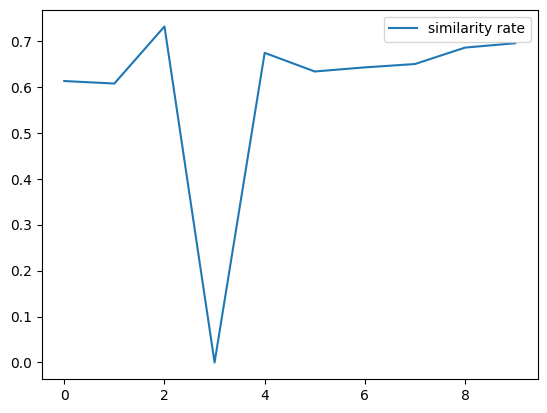

In [68]:
# plot the similarity rate and match rate
import matplotlib.pyplot as plt

# drop zero from similarity_rate_list
# similarity_rate_list = [x for x in similarity_rate_list if x != 0]

plt.plot(similarity_rate_list, label='similarity rate')
# plt.plot(match_rate_list, label='match rate')
plt.legend()
plt.show()

In [69]:
import pandas as pd

df =pd.read_csv("/home/com3dian/Github/meta-knowledge-harvesting-llm/data/vali_data_manully_extracted_V0.csv")
df

,Crop Type,Crop Yield,Crop Yield Unit,Climate Drivers,Climate Drivers Value,Climate Drivers Unit,Experimental Design,Location,Time,Source in paper,Title_of paper
0,maize,2,tons/ha,NAN,NAN,NAN,InfoCrop-MAIZE model simulations for past 25 y...,UIGP,baseline period-1970 to 1995,1. The mean baseline yield of rainfed maize cr...,"Byjesh 等 - 2010 - Simulating impacts, potentia..."
1,maize,-7,%,Atmospheric temperature,1,℃,InfoCrop-MAIZE model simulations for past 25 y...,UIGP,baseline period-1970 to 1995,1. The mean baseline yield of rainfed maize cr...,"Byjesh 等 - 2010 - Simulating impacts, potentia..."
2,maize,-11,%,Atmospheric temperature,2,℃,InfoCrop-MAIZE model simulations for past 25 y...,UIGP,baseline period-1970 to 1995,1. The mean baseline yield of rainfed maize cr...,"Byjesh 等 - 2010 - Simulating impacts, potentia..."
3,maize,-15,%,Atmospheric temperature,3,℃,InfoCrop-MAIZE model simulations for past 25 y...,UIGP,baseline period-1970 to 1995,1. The mean baseline yield of rainfed maize cr...,"Byjesh 等 - 2010 - Simulating impacts, potentia..."
4,maize,-22,%,Atmospheric temperature,4,℃,InfoCrop-MAIZE model simulations for past 25 y...,UIGP,baseline period-1970 to 1995,1. The mean baseline yield of rainfed maize cr...,"Byjesh 等 - 2010 - Simulating impacts, potentia..."
5,maize,-33,%,Atmospheric temperature,5,℃,InfoCrop-MAIZE model simulations for past 25 y...,UIGP,baseline period-1970 to 1995,1. The mean baseline yield of rainfed maize cr...,"Byjesh 等 - 2010 - Simulating impacts, potentia..."
6,maize,-8–-35,%,Atmospheric temperature,+1–+5,°C,InfoCrop-MAIZE model simulations for past 25 y...,MIGP,baseline period-1970 to 1995,"1. In MIGP region, yield reduction of about 8 ...","Byjesh 等 - 2010 - Simulating impacts, potentia..."
7,maize,-10,%,Atmospheric temperature,1,℃,InfoCrop-MAIZE model simulations for past 25 y...,SP,baseline period-1970 to 1995,1. The SP region also projected to experience ...,"Byjesh 等 - 2010 - Simulating impacts, potentia..."
8,maize,-15,%,Atmospheric temperature,2,℃,InfoCrop-MAIZE model simulations for past 25 y...,SP,baseline period-1970 to 1995,1. The SP region also projected to experience ...,"Byjesh 等 - 2010 - Simulating impacts, potentia..."
9,maize,-23,%,Atmospheric temperature,3,℃,InfoCrop-MAIZE model simulations for past 25 y...,SP,baseline period-1970 to 1995,1. The SP region also projected to experience ...,"Byjesh 等 - 2010 - Simulating impacts, potentia..."
